# **Importing basic libraries required for the project and define function to load datasets**

In [ ]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split


# define function to load datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 36) 

    return files, targets

# **Mounting google drive to download a dataset from there**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load train, test, and validation datasets**

In [ ]:

data_files, data_targets = load_dataset('/content/drive/MyDrive/ASL_FingerSpelling_Dataset') 
# load list of names
names = [item[17:19] for item in sorted(glob("/content/drive/MyDrive/ASL_FingerSpelling_Dataset/*/"))]

X_train, X_test, y_train, y_test = train_test_split(data_files, data_targets, test_size=0.2, random_state=42) 

# **Print statistics about the dataset**



In [ ]:

print('There are %s total images.\n' % len(np.hstack([X_train, X_test])))
print('There are %d training images.' % len(X_train))
print('There are %d total categories.' % len(names))
print('There are %d testing images.' % len(X_test))


There are 2515 total images.

There are 2012 training images.
There are 36 total categories.
There are 503 testing images.


# **Pre-process the Data**

In [ ]:
# Pre-process the Data
!pip install keras_preprocessing

from keras_preprocessing import image                  ## ready the image 
from tqdm import tqdm

def path_to_tensor(img_path): ## chagne them to a tensor 
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **pre-process the data for Keras**

In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_targets=y_train
test_targets=y_test
train_tensors = paths_to_tensor(X_train).astype('float32')/255
test_tensors = paths_to_tensor(X_test).astype('float32')/255

100%|██████████| 503/503 [00:03<00:00, 131.83it/s]


# **Building a VGG16 model**

In [ ]:
from keras.applications.vgg16 import VGG16 ## (none,none,none)
model = VGG16(include_top=False)
model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

# **Training images**

In [ ]:
bottleneck_features_train_VGG16 = np.asarray([model.predict(np.expand_dims(tensor, axis=0), verbose=1)[0] for tensor in train_tensors],dtype=np.float32) ## Turning them into features

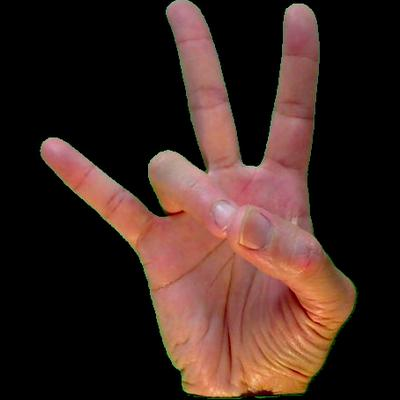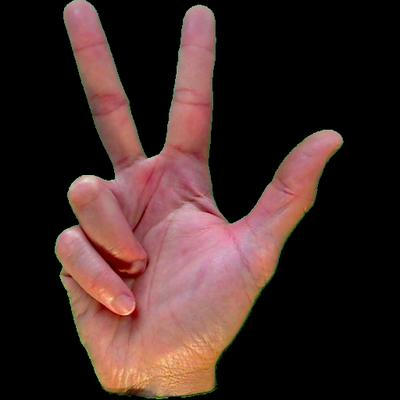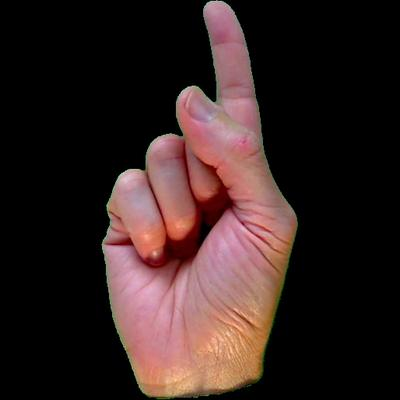

# **Test images**

In [ ]:
bottleneck_features_test_VGG16 = np.asarray([model.predict(np.expand_dims(tensor, axis=0), verbose=1)[0] for tensor in test_tensors],dtype=np.float32)

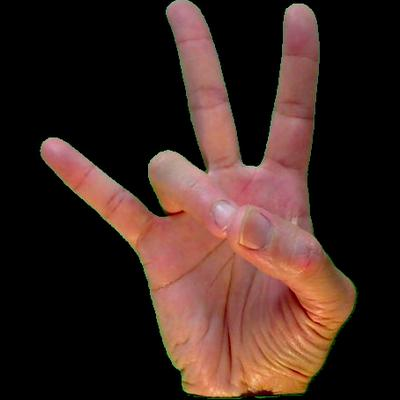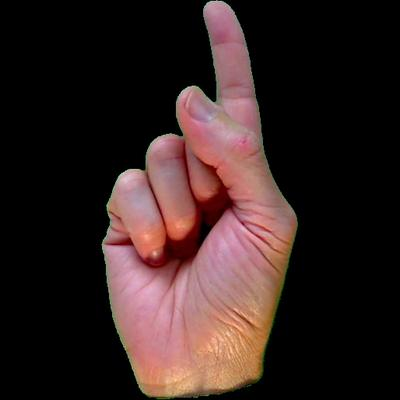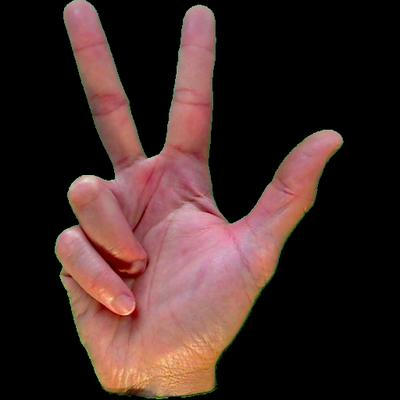

In [ ]:
print(bottleneck_features_train_VGG16.shape) 
print(bottleneck_features_test_VGG16.shape)

(2012, 7, 7, 512)
(503, 7, 7, 512)


In [ ]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D ## training part the pics are ready
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

Model = Sequential() ## name of the model
Model.add(Flatten(input_shape=bottleneck_features_train_VGG16.shape[1:])) ## you seperate them all the 512 
Model.add(Dense(250, activation='relu',kernel_initializer='glorot_normal')) ## try to change the dense, 500 hidden units
##Model1.add(Dense(250, activation='relu',kernel_initializer='glorot_normal')) 
##Model1.add(Dense(100, activation='relu',kernel_initializer='glorot_normal')) 
##Model1.add(Dense(50, activation='relu',kernel_initializer='glorot_normal')) 
Model.add(Dropout(0.5))
Model.add(Dense(36, activation='softmax',kernel_initializer='glorot_normal')) ## 36 classification output 
Model.summary()                   

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 250)               6272250   
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 36)                9036      
                                                                 
Total params: 6,281,286
Trainable params: 6,281,286
Non-trainable params: 0
_________________________________________________________________


# Training the model with the best parameters


In [ ]:
Model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']) 
##Model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
##Model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
##Model.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
##Model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
from keras.callbacks import ModelCheckpoint

In [ ]:

checkpointer = ModelCheckpoint(filepath='/content/sample_data/weights.best.VGG16.hdf5_transfer_learning', 
                               monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history=Model.fit(bottleneck_features_train_VGG16, train_targets, validation_split=0.1, epochs=100, batch_size=16, callbacks=[checkpointer], verbose=1)

Epoch 1/100
113/114 [============================>.] - ETA: 0s - loss: 3.2559 - accuracy: 0.2378
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/sample_data/weights.best.VGG16.hdf5_transfer_learning


114/114 [==============================] - 7s 52ms/step - loss: 3.2537 - accuracy: 0.2387 - val_loss: 1.5675 - val_accuracy: 0.5000
Epoch 2/100
113/114 [============================>.] - ETA: 0s - loss: 1.5274 - accuracy: 0.5315
Epoch 2: val_accuracy improved from 0.50000 to 0.74257, saving model to /content/sample_data/weights.best.VGG16.hdf5_transfer_learning


114/114 [==============================] - 7s 61ms/step - loss: 1.5262 - accuracy: 0.5320 - val_loss: 0.9112 - val_accuracy: 0.7426
Epoch 3/100
114/114 [==============================] - ETA: 0s - loss: 1.0517 - accuracy: 0.6674
Epoch 3: val_accuracy improved from 0.74257 to 0.83168, saving model to /content/sample_data/weights.best.VGG16.hdf5_transfer_learning


114/114 [==============================] - 6s 49ms/step - loss: 1.0517 - accuracy: 0.6674 - val_loss: 0.4413 - val_accuracy: 0.8317
Epoch 4/100
114/114 [==============================] - ETA: 0s - loss: 0.8269 - accuracy: 0.7331
Epoch 4: val_accuracy improved from 0.83168 to 0.87129, saving model to /content/sample_data/weights.best.VGG16.hdf5_transfer_learning


114/114 [==============================] - 6s 56ms/step - loss: 0.8269 - accuracy: 0.7331 - val_loss: 0.3074 - val_accuracy: 0.8713
Epoch 5/100
114/114 [==============================] - ETA: 0s - loss: 0.6707 - accuracy: 0.7691
Epoch 5: val_accuracy improved from 0.87129 to 0.93069, saving model to /content/sample_data/weights.best.VGG16.hdf5_transfer_learning


114/114 [==============================] - 5s 47ms/step - loss: 0.6707 - accuracy: 0.7691 - val_loss: 0.2090 - val_accuracy: 0.9307
Epoch 6/100
113/114 [============================>.] - ETA: 0s - loss: 0.5443 - accuracy: 0.7987
Epoch 6: val_accuracy did not improve from 0.93069
114/114 [==============================] - 5s 45ms/step - loss: 0.5444 - accuracy: 0.7983 - val_loss: 0.3562 - val_accuracy: 0.8861
Epoch 7/100
114/114 [==============================] - ETA: 0s - loss: 0.4659 - accuracy: 0.8442
Epoch 7: val_accuracy improved from 0.93069 to 0.93564, saving model to /content/sample_data/weights.best.VGG16.hdf5_transfer_learning


114/114 [==============================] - 6s 53ms/step - loss: 0.4659 - accuracy: 0.8442 - val_loss: 0.1407 - val_accuracy: 0.9356
Epoch 8/100
113/114 [============================>.] - ETA: 0s - loss: 0.4337 - accuracy: 0.8440
Epoch 8: val_accuracy improved from 0.93564 to 0.97525, saving model to /content/sample_data/weights.best.VGG16.hdf5_transfer_learning


114/114 [==============================] - 5s 46ms/step - loss: 0.4344 - accuracy: 0.8436 - val_loss: 0.1053 - val_accuracy: 0.9752
Epoch 9/100
113/114 [============================>.] - ETA: 0s - loss: 0.3961 - accuracy: 0.8590
Epoch 9: val_accuracy did not improve from 0.97525
114/114 [==============================] - 6s 50ms/step - loss: 0.3957 - accuracy: 0.8591 - val_loss: 0.0820 - val_accuracy: 0.9653
Epoch 10/100
113/114 [============================>.] - ETA: 0s - loss: 0.3699 - accuracy: 0.8662
Epoch 10: val_accuracy did not improve from 0.97525
114/114 [==============================] - 5s 41ms/step - loss: 0.3695 - accuracy: 0.8663 - val_loss: 0.0813 - val_accuracy: 0.9653
Epoch 11/100
114/114 [==============================] - ETA: 0s - loss: 0.3751 - accuracy: 0.8790
Epoch 11: val_accuracy did not improve from 0.97525
114/114 [==============================] - 5s 45ms/step - loss: 0.3751 - accuracy: 0.8790 - val_loss: 0.1517 - val_accuracy: 0.9307
Epoch 12/100
114/114 [==

114/114 [==============================] - 6s 54ms/step - loss: 0.2187 - accuracy: 0.9320 - val_loss: 0.0285 - val_accuracy: 0.9901
Epoch 28/100
114/114 [==============================] - ETA: 0s - loss: 0.1787 - accuracy: 0.9420
Epoch 28: val_accuracy did not improve from 0.99010
114/114 [==============================] - 5s 40ms/step - loss: 0.1787 - accuracy: 0.9420 - val_loss: 0.0522 - val_accuracy: 0.9851
Epoch 29/100
114/114 [==============================] - ETA: 0s - loss: 0.2090 - accuracy: 0.9282
Epoch 29: val_accuracy did not improve from 0.99010
114/114 [==============================] - 5s 46ms/step - loss: 0.2090 - accuracy: 0.9282 - val_loss: 0.1193 - val_accuracy: 0.9554
Epoch 30/100
114/114 [==============================] - ETA: 0s - loss: 0.1800 - accuracy: 0.9387
Epoch 30: val_accuracy did not improve from 0.99010
114/114 [==============================] - 5s 43ms/step - loss: 0.1800 - accuracy: 0.9387 - val_loss: 0.0530 - val_accuracy: 0.9851
Epoch 31/100
113/114 [

114/114 [==============================] - 6s 56ms/step - loss: 0.1172 - accuracy: 0.9635 - val_loss: 0.0385 - val_accuracy: 0.9950
Epoch 54/100
114/114 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.9558
Epoch 54: val_accuracy did not improve from 0.99505
114/114 [==============================] - 5s 41ms/step - loss: 0.1338 - accuracy: 0.9558 - val_loss: 0.0689 - val_accuracy: 0.9851
Epoch 55/100
113/114 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9569
Epoch 55: val_accuracy did not improve from 0.99505
114/114 [==============================] - 5s 48ms/step - loss: 0.1531 - accuracy: 0.9569 - val_loss: 0.0447 - val_accuracy: 0.9802
Epoch 56/100
113/114 [============================>.] - ETA: 0s - loss: 0.1298 - accuracy: 0.9541
Epoch 56: val_accuracy did not improve from 0.99505
114/114 [==============================] - 5s 42ms/step - loss: 0.1297 - accuracy: 0.9541 - val_loss: 0.1085 - val_accuracy: 0.9653
Epoch 57/100
113/114 [

114/114 [==============================] - 6s 55ms/step - loss: 0.0974 - accuracy: 0.9685 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 87/100
113/114 [============================>.] - ETA: 0s - loss: 0.0889 - accuracy: 0.9690
Epoch 87: val_accuracy did not improve from 1.00000
114/114 [==============================] - 5s 44ms/step - loss: 0.0888 - accuracy: 0.9691 - val_loss: 0.0177 - val_accuracy: 0.9950
Epoch 88/100
113/114 [============================>.] - ETA: 0s - loss: 0.0893 - accuracy: 0.9685
Epoch 88: val_accuracy did not improve from 1.00000
114/114 [==============================] - 5s 41ms/step - loss: 0.0892 - accuracy: 0.9685 - val_loss: 0.0133 - val_accuracy: 0.9950
Epoch 89/100
114/114 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.9757
Epoch 89: val_accuracy did not improve from 1.00000
114/114 [==============================] - 6s 51ms/step - loss: 0.0854 - accuracy: 0.9757 - val_loss: 0.0617 - val_accuracy: 0.9851
Epoch 90/100
113/114 [

In [ ]:
Model2 = Sequential()
Model2.add(Flatten(input_shape=bottleneck_features_train_VGG16.shape[1:]))
##Model2.add(Dense(500, activation='relu',kernel_initializer='glorot_normal')) 
Model2.add(Dense(250, activation='relu',kernel_initializer='glorot_normal')) 
##Model2.add(Dense(100, activation='relu',kernel_initializer='glorot_normal')) 
##Model2.add(Dense(50, activation='relu',kernel_initializer='glorot_normal')) 
##Model2.add(Dropout(0.5))
Model2.add(Dense(36, activation='softmax',kernel_initializer='glorot_normal'))
Model2.summary()
Model2.load_weights('/content/sample_data/weights.best.VGG16.hdf5_transfer_learning')
import time
# Start timing
start_time = time.time()
VGG16_predictions = [Model2.predict(np.expand_dims(tensor, axis=0))[0] for tensor in bottleneck_features_test_VGG16]
# End timing
end_time = time.time()
print("Time Taken: {} seconds".format(end_time-start_time))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 250)               6272250   
                                                                 
 dense_3 (Dense)             (None, 36)                9036      
                                                                 
Total params: 6,281,286
Trainable params: 6,281,286
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 27ms/step
Time Taken: 40.45574164390564 seconds


# **Report test accuracy**

In [ ]:

predicted_classes = np.argmax(np.round(VGG16_predictions),axis=1)
test_classes = np.argmax(np.round(test_targets),axis=1)
from sklearn.metrics import classification_report
print(classification_report(test_classes, predicted_classes))
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(test_classes, predicted_classes)
print(confusion_mtx)


              precision    recall  f1-score   support

           0       0.94      1.00      0.97        16
           1       0.85      1.00      0.92        11
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00        13
           5       1.00      1.00      1.00        17
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00        13
           8       1.00      1.00      1.00        16
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        19
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00        11
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        19
          15       1.00      1.00      1.00        11
          16       1.00      1.00      1.00        21
          17       1.00    